In [1]:
# %load extract_embeddings.py
# USAGE
# python extract_embeddings.py --dataset dataset --embeddings output/embeddings.pickle \
#	--detector face_detection_model --embedding-model openface_nn4.small2.v1.t7

# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import serial
from IPython.display import Image

In [2]:
#hardcoding argument paths 
args = {
  "dataset": "dataset",
  "embeddings": "output/embeddings.pickle",
  "detector": "face_detection_model",
  "embedding_model": "openface_nn4.small2.v1.t7",
  "confidence": 0.5
}

In [3]:
# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join([args["detector"], "deploy.prototxt"])
modelPath = os.path.sep.join([args["detector"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(args["embedding_model"])

# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(args["dataset"]))

# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []

# initialize the total number of faces processed
total = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]

	# load the image, resize it to have a width of 600 pixels (while
	# maintaining the aspect ratio), and then grab the image
	# dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# construct a blob from the image
	imageBlob = cv2.dnn.blobFromImage(
		cv2.resize(image, (300, 300)), 1.0, (300, 300),
		(104.0, 177.0, 123.0), swapRB=False, crop=False)

	# apply OpenCV's deep learning-based face detector to localize
	# faces in the input image
	detector.setInput(imageBlob)
	detections = detector.forward()

	# ensure at least one face was found
	if len(detections) > 0:
		# we're making the assumption that each image has only ONE
		# face, so find the bounding box with the largest probability
		i = np.argmax(detections[0, 0, :, 2])
		confidence = detections[0, 0, i, 2]

		# ensure that the detection with the largest probability also
		# means our minimum probability test (thus helping filter out
		# weak detections)
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the face
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# extract the face ROI and grab the ROI dimensions
			face = image[startY:endY, startX:endX]
			(fH, fW) = face.shape[:2]

			# ensure the face width and height are sufficiently large
			if fW < 20 or fH < 20:
				continue

			# construct a blob for the face ROI, then pass the blob
			# through our face embedding model to obtain the 128-d
			# quantification of the face
			faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
				(96, 96), (0, 0, 0), swapRB=True, crop=False)
			embedder.setInput(faceBlob)
			vec = embedder.forward()

			# add the name of the person + corresponding face
			# embedding to their respective lists
			knownNames.append(name)
			knownEmbeddings.append(vec.flatten())
			total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open(args["embeddings"], "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] loading face detector...
[INFO] loading face recognizer...
[INFO] quantifying faces...
[INFO] processing image 1/75
[INFO] processing image 2/75
[INFO] processing image 3/75
[INFO] processing image 4/75
[INFO] processing image 5/75
[INFO] processing image 6/75
[INFO] processing image 7/75
[INFO] processing image 8/75
[INFO] processing image 9/75
[INFO] processing image 10/75
[INFO] processing image 11/75
[INFO] processing image 12/75
[INFO] processing image 13/75
[INFO] processing image 14/75
[INFO] processing image 15/75
[INFO] processing image 16/75
[INFO] processing image 17/75
[INFO] processing image 18/75
[INFO] processing image 19/75
[INFO] processing image 20/75
[INFO] processing image 21/75
[INFO] processing image 22/75
[INFO] processing image 23/75
[INFO] processing image 24/75
[INFO] processing image 25/75
[INFO] processing image 26/75
[INFO] processing image 27/75
[INFO] processing image 28/75
[INFO] processing image 29/75
[INFO] processing image 30/75
[INFO] processi

In [4]:
# %load train_model.py
# USAGE
# python train_model.py --embeddings output/embeddings.pickle \
#	--recognizer output/recognizer.pickle --le output/le.pickle

# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import argparse
import pickle

#hardcoding arguments
args = {
  "dataset": "dataset",
  "embeddings": "output/embeddings.pickle",
  "recognizer": "output/recognizer.pickle",
  "le": "output/le.pickle",
}

# load the face embeddings
print("[INFO] loading face embeddings...")
data = pickle.loads(open(args["embeddings"], "rb").read())

# encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

# train the model used to accept the 128-d embeddings of the face and
# then produce the actual face recognition
print("[INFO] training model...")
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data["embeddings"], labels)

# write the actual face recognition model to disk
f = open(args["recognizer"], "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(args["le"], "wb")
f.write(pickle.dumps(le))
f.close()

[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...


In [5]:
# %load recognize.py
# USAGE
# python recognize.py --detector face_detection_model \
#	--embedding-model openface_nn4.small2.v1.t7 \
#	--recognizer output/recognizer.pickle \
#	--le output/le.pickle --image images/adrian.jpg

# import the necessary packages
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

# construct the argument parser and parse the arguments
'''
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-d", "--detector", required=True,
	help="path to OpenCV's deep learning face detector")
ap.add_argument("-m", "--embedding-model", required=True,
	help="path to OpenCV's deep learning face embedding model")
ap.add_argument("-r", "--recognizer", required=True,
	help="path to model trained to recognize faces")
ap.add_argument("-l", "--le", required=True,
	help="path to label encoder")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())
'''
args = {
    "detector" : "face_detection_model",
    "embedding_model" : "openface_nn4.small2.v1.t7",
    "recognizer" : "output/recognizer.pickle",
    "le" : "output/le.pickle",
    "image" : "images/david.jpg",
    "confidence" : 0.5
}

# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join([args["detector"], "deploy.prototxt"])
modelPath = os.path.sep.join([args["detector"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(args["embedding_model"])

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(args["recognizer"], "rb").read())
le = pickle.loads(open(args["le"], "rb").read())

# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
	cv2.resize(image, (300, 300)), 1.0, (300, 300),
	(104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob
		# through our face embedding model to obtain the 128-d
		# quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]

		# draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
cv2.imshow("Image", image)
cv2.waitKey(0)


[INFO] loading face detector...
[INFO] loading face recognizer...


13

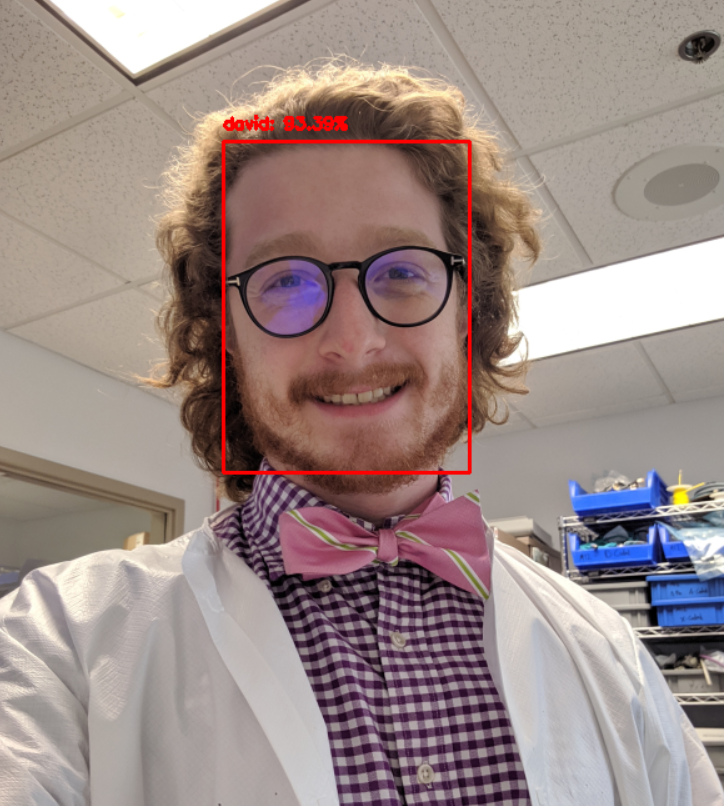

In [6]:
#this is what cv2.imshow("Image", image) above shows
#reshowing image for the sake of presentation incase code not ran live
Image("output/david_identified_for_demo.PNG" )

In [7]:
# neccessary libraries for talking to arduino
import serial #Serial imported for Serial communication
import time #Required to use delay functions


ArduinoSerial = serial.Serial('com11',9600) # comport may change. look it up in arduino ide
time.sleep(2)
print (ArduinoSerial.readline())


b'hi im arduino\r\n'


In [8]:
if name == "david":
    
    print('we found david sending the beacon')
    packege = '1'
    ArduinoSerial.write(packege.encode())
    
else:
    print('we found '+ name)
    packege = '0'
    ArduinoSerial.write(packege.encode())

we found david sending the beacon


In [10]:
""" arduino code 
void setup() {
  // put your setup code here, to run once:
  Serial.begin(9600);
  pinMode(LED_BUILTIN, OUTPUT);
  digitalWrite(LED_BUILTIN, HIGH);   // turn the LED on (HIGH is the voltage level)
  delay(1000);                       // wait for a second
  digitalWrite(LED_BUILTIN, LOW);    // turn the LED off by making the voltage LOW
  delay(1000);
  

  Serial.println("hi im arduino"); // this should appear on other computer
  

}


void loop() {
  // put your main code here, to run repeatedly:
  char data;
   
  while (Serial.available())
  {
    data = Serial.read();
  }
  if (data == '1')
  {
    digitalWrite(13,1);
  }
  if (data == '0')
  {
    digitalWrite(13,0);
  }
 
}
"""

' arduino code \nvoid setup() {\n  // put your setup code here, to run once:\n  Serial.begin(9600);\n  pinMode(LED_BUILTIN, OUTPUT);\n  digitalWrite(LED_BUILTIN, HIGH);   // turn the LED on (HIGH is the voltage level)\n  delay(1000);                       // wait for a second\n  digitalWrite(LED_BUILTIN, LOW);    // turn the LED off by making the voltage LOW\n  delay(1000);\n  \n\n  Serial.println("hi im arduino"); // this should appear on other computer\n  \n\n}\n\n\nvoid loop() {\n  // put your main code here, to run repeatedly:\n  char data;\n   \n  while (Serial.available())\n  {\n    data = Serial.read();\n  }\n  if (data == \'1\')\n  {\n    digitalWrite(13,1);\n  }\n  if (data == \'0\')\n  {\n    digitalWrite(13,0);\n  }\n \n}\n'